# EDA of traffic data from different sources
- https://opendata.paris.fr/explore/dataset/comptages-routiers-permanents-2019/
- https://parisdata.opendatasoft.com/explore/dataset/referentiel-comptages-routiers/

Goal : explore and understand data from the Open data platform of Paris to prepare a pipeline to predict future traffic jams

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
sns.set()
%matplotlib inline

## Datasets
We know that the datasets can be merged with the 'iu_ac' column, but let's check them first.

In [2]:
paris = pd.read_csv('data/paris.csv', delimiter=';')

In [3]:
print(paris.shape)
paris.head()

(300000, 11)


iu_ac           libelle  iu_nd_amont         libelle_nd_amont  iu_nd_aval  \
0   5432       PI_Dauphine         2796              SI_Dauphine        2800   
1   7205      Menilmontant         3734  Menilmontant-Jakubowicz         674   
2   6626  Av_Simon_Bolivar         3433     Lauzin-Simon_Bolivar        3434   
3    703            Alesia          403           Alesia-Plantes         396   
4   6018      Bd_Haussmann         3117        Haussmann_Teheran        2271   

           libelle_nd_aval                       t_1h       q        k  \
0              AI_Dauphine  2019-10-01T00:00:00+00:00  2994.0  5.95000   
1  Menilmontant-St_Fargeau  2019-10-01T00:00:00+00:00   185.0      NaN   
2      Manin-Simon_Bolivar  2019-10-01T00:00:00+00:00   200.0  2.72611   
3          Pl_Victor_Basch  2019-10-01T00:00:00+00:00   296.0      NaN   
4       Bd_Haussmann-Musee  2019-10-01T00:00:00+00:00   692.0  3.45667   

   etat_trafic                                             dessin  
0            1  "<PLINE><PT X=""595544"" Y=""130404""/><PT X="...  
1            0  "<PLINE EPAISSEUR=""10""><PT X=""604457"" Y=""...  
2            1  "<PLINE><PT X=""603053"" Y=""130660""/><PT X="...  
3            0  "<PLINE COURBE=""1""><PT X=""599275"" Y=""1252...  
4            1  "<PLINE><PT X=""598092"" Y=""130525""/><PT X="...

In [4]:
paris.tail()

iu_ac        libelle  iu_nd_amont                libelle_nd_amont  \
299995   5299        PI_Ivry          551                         SI_Ivry   
299996   1887  Av_de_St_Ouen         2042    Av_St_Ouen-Passage_St_Michel   
299997   4612  Av_Pdt_Wilson         3445                  Place_de_Tokyo   
299998   4989        Tolbiac         2642             Tolbiac-Av_d'Italie   
299999   1427     Bd_Mortier          757  Bd_Mortier-Av_Pte_Menilmontant   

        iu_nd_aval                libelle_nd_aval                       t_1h  \
299995         572                        AI_Ivry  2019-09-27T06:00:00+00:00   
299996        2043        Av_St_Ouen-Av_de_Clichy  2019-09-27T06:00:00+00:00   
299997        2345       Av_Marceau-Av_Pdt_Wilson  2019-09-27T06:00:00+00:00   
299998        2641        Tolbiac-Moulin_des_Pres  2019-09-27T06:00:00+00:00   
299999         758  Bd_Mortier-Vidal_de_la_Blache  2019-09-27T06:00:00+00:00   

             q         k  etat_trafic  \
299995  3837.0  11.20000            1   
299996    84.0       NaN            0   
299997    89.0   0.98778            1   
299998     NaN       NaN            0   
299999     5.0   0.16222            1   

                                                   dessin  
299995  "<PLINE><PT X=""602700"" Y=""124359""/><PT X="...  
299996  "<PLINE EPAISSEUR=""6""><PT X=""599211"" Y=""1...  
299997  "<PLINE><PT X=""597323"" Y=""129394""/><PT X="...  
299998  "<PLINE><PT X=""601265"" Y=""125066""/><PT X="...  
299999  "<PLINE><PT X=""605294"" Y=""130016""/><PT X="...

We notice that there are 3308 node points on this dataset. We downloaded data from January to September for easiest management.

In [5]:
len(paris['iu_ac'].unique())

3308

In [6]:
geo = pd.read_csv('data/referentiel-comptages-routiers.csv', delimiter=';')

In [7]:
print(geo.shape)
geo.head()

(3739, 11)


IU_AC                 DATE_DEBUT                   DATE_FIN  \
0   6012  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00   
1    214  2005-01-01T02:00:00+01:00  2016-07-13T04:00:00+02:00   
2   6358  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00   
3   6372  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00   
4   5866  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00   

          LIBELLE  IU_ND_AVAL  IU_ND_AMONT             LIBELLE_ND_AMONT  \
0    Bd_Haussmann        3114         3113              Haussmann-Anjou   
1             VGP          56          131  Sortie_Souterrain_Tuileries   
2     Bd_Voltaire        2526         3289           Bd_Voltaire-Guenot   
3  Bd_de_Charonne        3302         2531         Bd_Charonne-Vignoles   
4        Bd_Bercy        2591         3044              Bercy-Souterain   

               LIBELLE_ND_AVAL                 geo_point_2d  \
0               Pl_St_Augustin  48.8745254246,2.32143206793   
1          VGP-Edouard_Colonne  48.8582822847,2.34233678115   
2  Bd_Voltaire-Boulets-A.Dumas  48.8522029627,2.38963160674   
3  Bd_Charonne-Alexandre_Dumas  48.8537272304,2.39669405538   
4           Bd_Bercy-Corbineau  48.8397463472,2.38391820799   

                                           geo_shape  SHAPE.LEN  
0  {"type": "LineString", "coordinates": [[2.3227...        0.0  
1  {"type": "LineString", "coordinates": [[2.3403...        0.0  
2  {"type": "LineString", "coordinates": [[2.3905...        0.0  
3  {"type": "LineString", "coordinates": [[2.3972...        0.0  
4  {"type": "LineString", "coordinates": [[2.3855...        0.0

There are 3348 nodes : it seems logical, because this dataset represents every geographic points.

In [8]:
len(geo['IU_AC'].unique())

3348

The type of the 'iu_ac' columns are differents in the two datasets, we need to correct that before merging.

In [9]:
print('Presence of cars on the road data : \n', paris.dtypes)
print('\nGeographic data: \n', geo.dtypes)

Presence of cars on the road data : 
 iu_ac                 int64
libelle              object
iu_nd_amont           int64
libelle_nd_amont     object
iu_nd_aval            int64
libelle_nd_aval      object
t_1h                 object
q                   float64
k                   float64
etat_trafic           int64
dessin               object
dtype: object

Geographic data: 
 IU_AC                 int64
DATE_DEBUT           object
DATE_FIN             object
LIBELLE              object
IU_ND_AVAL            int64
IU_ND_AMONT           int64
LIBELLE_ND_AMONT     object
LIBELLE_ND_AVAL      object
geo_point_2d         object
geo_shape            object
SHAPE.LEN           float64
dtype: object


In [10]:
paris['iu_ac'] = paris['iu_ac'].astype('float')

We merge the datasets to obtain a workable one.

In [11]:
df = pd.merge(paris, geo, left_on='iu_ac', right_on='IU_AC')

In [12]:
df.head()

iu_ac      libelle  iu_nd_amont libelle_nd_amont  iu_nd_aval  \
0  5432.0  PI_Dauphine         2796      SI_Dauphine        2800   
1  5432.0  PI_Dauphine         2796      SI_Dauphine        2800   
2  5432.0  PI_Dauphine         2796      SI_Dauphine        2800   
3  5432.0  PI_Dauphine         2796      SI_Dauphine        2800   
4  5432.0  PI_Dauphine         2796      SI_Dauphine        2800   

  libelle_nd_aval                       t_1h       q      k  etat_trafic  ...  \
0     AI_Dauphine  2019-10-01T00:00:00+00:00  2994.0   5.95            1  ...   
1     AI_Dauphine  2019-09-30T23:00:00+00:00  3309.0   6.70            1  ...   
2     AI_Dauphine  2019-09-30T22:00:00+00:00  3893.0   7.95            1  ...   
3     AI_Dauphine  2019-09-30T21:00:00+00:00  5312.0  11.10            1  ...   
4     AI_Dauphine  2019-09-30T20:00:00+00:00  5557.0  17.00            2  ...   

                  DATE_DEBUT                   DATE_FIN      LIBELLE  \
0  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00  PI_Dauphine   
1  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00  PI_Dauphine   
2  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00  PI_Dauphine   
3  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00  PI_Dauphine   
4  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00  PI_Dauphine   

  IU_ND_AVAL IU_ND_AMONT  LIBELLE_ND_AMONT  LIBELLE_ND_AVAL  \
0       2800        2796       SI_Dauphine      AI_Dauphine   
1       2800        2796       SI_Dauphine      AI_Dauphine   
2       2800        2796       SI_Dauphine      AI_Dauphine   
3       2800        2796       SI_Dauphine      AI_Dauphine   
4       2800        2796       SI_Dauphine      AI_Dauphine   

                  geo_point_2d  \
0  48.8718437703,2.27366055572   
1  48.8718437703,2.27366055572   
2  48.8718437703,2.27366055572   
3  48.8718437703,2.27366055572   
4  48.8718437703,2.27366055572   

                                           geo_shape SHAPE.LEN  
0  {"type": "LineString", "coordinates": [[2.2718...       0.0  
1  {"type": "LineString", "coordinates": [[2.2718...       0.0  
2  {"type": "LineString", "coordinates": [[2.2718...       0.0  
3  {"type": "LineString", "coordinates": [[2.2718...       0.0  
4  {"type": "LineString", "coordinates": [[2.2718...       0.0  

[5 rows x 22 columns]

In [13]:
df.tail()

iu_ac  libelle  iu_nd_amont  libelle_nd_amont  iu_nd_aval  \
335165  4967.0  Tolbiac         2629  Tolbiac-Barrault        2628   
335166  4967.0  Tolbiac         2629  Tolbiac-Barrault        2628   
335167  4967.0  Tolbiac         2629  Tolbiac-Barrault        2628   
335168  4967.0  Tolbiac         2629  Tolbiac-Barrault        2628   
335169  4967.0  Tolbiac         2629  Tolbiac-Barrault        2628   

          libelle_nd_aval                       t_1h   q   k  etat_trafic  \
335165  Tolbiac-Vergniaud  2019-09-27T10:00:00+00:00 NaN NaN            0   
335166  Tolbiac-Vergniaud  2019-09-27T09:00:00+00:00 NaN NaN            0   
335167  Tolbiac-Vergniaud  2019-09-27T08:00:00+00:00 NaN NaN            0   
335168  Tolbiac-Vergniaud  2019-09-27T07:00:00+00:00 NaN NaN            0   
335169  Tolbiac-Vergniaud  2019-09-27T06:00:00+00:00 NaN NaN            0   

        ...                 DATE_DEBUT                   DATE_FIN  LIBELLE  \
335165  ...  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00  Tolbiac   
335166  ...  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00  Tolbiac   
335167  ...  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00  Tolbiac   
335168  ...  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00  Tolbiac   
335169  ...  2005-01-01T02:00:00+01:00  2019-06-01T04:00:00+02:00  Tolbiac   

       IU_ND_AVAL IU_ND_AMONT  LIBELLE_ND_AMONT    LIBELLE_ND_AVAL  \
335165       2628        2629  Tolbiac-Barrault  Tolbiac-Vergniaud   
335166       2628        2629  Tolbiac-Barrault  Tolbiac-Vergniaud   
335167       2628        2629  Tolbiac-Barrault  Tolbiac-Vergniaud   
335168       2628        2629  Tolbiac-Barrault  Tolbiac-Vergniaud   
335169       2628        2629  Tolbiac-Barrault  Tolbiac-Vergniaud   

                       geo_point_2d  \
335165  48.8258425931,2.34623362632   
335166  48.8258425931,2.34623362632   
335167  48.8258425931,2.34623362632   
335168  48.8258425931,2.34623362632   
335169  48.8258425931,2.34623362632   

                                                geo_shape SHAPE.LEN  
335165  {"type": "LineString", "coordinates": [[2.3472...       0.0  
335166  {"type": "LineString", "coordinates": [[2.3472...       0.0  
335167  {"type": "LineString", "coordinates": [[2.3472...       0.0  
335168  {"type": "LineString", "coordinates": [[2.3472...       0.0  
335169  {"type": "LineString", "coordinates": [[2.3472...       0.0  

[5 rows x 22 columns]

We now have a dataset with all the informations we want.

In [14]:
len(df['iu_ac'].unique())

3307

In [15]:
df.shape

(335170, 22)

In [16]:
df.describe()

iu_ac    iu_nd_amont     iu_nd_aval              q  \
count  335170.000000  335170.000000  335170.000000  183537.000000   
mean     3649.286279    1816.652388    1812.820261     735.733324   
std      2320.111288    1195.305705    1191.761620    1098.602109   
min         1.000000       0.000000       0.000000       0.000000   
25%      1248.000000     581.000000     581.000000     213.000000   
50%      4534.000000    2319.000000    2318.000000     419.000000   
75%      5567.000000    2854.000000    2840.000000     768.000000   
max      7219.000000    3737.000000    3740.000000    9330.000000   

                   k    etat_trafic          IU_AC     IU_ND_AVAL  \
count  189236.000000  335170.000000  335170.000000  335170.000000   
mean        7.649669       0.668619    3649.286279    1811.849906   
std        10.131712       0.710177    2320.111288    1191.645841   
min         0.000000       0.000000       1.000000       0.000000   
25%         1.832083       0.000000    1248.000000     581.000000   
50%         4.321670       1.000000    4534.000000    2317.000000   
75%         8.960140       1.000000    5567.000000    2839.000000   
max        97.725600       4.000000    7219.000000    3737.000000   

         IU_ND_AMONT  SHAPE.LEN  
count  335170.000000   335170.0  
mean     1816.634565        0.0  
std      1195.330616        0.0  
min         0.000000        0.0  
25%       581.000000        0.0  
50%      2319.000000        0.0  
75%      2854.000000        0.0  
max      3737.000000        0.0

## Pre-processing
We need to get rid of some useless columns and make the rest understandable for a ML model.

According to the data documentation, the useful columns we're gonna need are :
- iu_ac : the unique identifier of the arc of traffic data
- iu_nd_amont : unique identifier of previous arc
- iu_nd_aval : unique identifier of next arc
- t_1h : timestamp of the record (/!\ we need to convert the format of this column)
- q : outflow (number of cars counted during one hour)
- etat_trafic : state of the trafic (0: unknown, 1: fluid, 2: pre-saturated, 3: saturated, 4: complety stopped)
- geo_point_2d : latitude and longitude (to split)

In [17]:
columns_to_keep = ['iu_ac', 'iu_nd_amont', 'iu_nd_aval', 't_1h', 'q', 'etat_trafic', 'geo_point_2d']
df = df[columns_to_keep]

In [18]:
df.head()

iu_ac  iu_nd_amont  iu_nd_aval                       t_1h       q  \
0  5432.0         2796        2800  2019-10-01T00:00:00+00:00  2994.0   
1  5432.0         2796        2800  2019-09-30T23:00:00+00:00  3309.0   
2  5432.0         2796        2800  2019-09-30T22:00:00+00:00  3893.0   
3  5432.0         2796        2800  2019-09-30T21:00:00+00:00  5312.0   
4  5432.0         2796        2800  2019-09-30T20:00:00+00:00  5557.0   

   etat_trafic                 geo_point_2d  
0            1  48.8718437703,2.27366055572  
1            1  48.8718437703,2.27366055572  
2            1  48.8718437703,2.27366055572  
3            1  48.8718437703,2.27366055572  
4            2  48.8718437703,2.27366055572

In [19]:
df.dtypes

iu_ac           float64
iu_nd_amont       int64
iu_nd_aval        int64
t_1h             object
q               float64
etat_trafic       int64
geo_point_2d     object
dtype: object

We tranform the floating data in integer, the geo point coordinates in latitude and longitude, and we transform the t_1h in a datetime column.

In [20]:
df['iu_ac'] = df['iu_ac'].astype('int64')

In [21]:
df['lat'], df['long'] = df['geo_point_2d'].str.split(',', 1).str
df.drop(['geo_point_2d'], axis=1, inplace=True)

In [22]:
df['lat'] = df['lat'].astype('float')
df['long'] = df['long'].astype('float')

In [23]:
df['datetime'] = pd.to_datetime(df['t_1h'], format='%Y-%m-%d')
df.drop(['t_1h'], axis=1, inplace=True)

In [24]:
df = df.set_index('datetime')

In [25]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday
df['Hour'] = df.index.hour

In [26]:
pd.isnull(df).sum()

iu_ac               0
iu_nd_amont         0
iu_nd_aval          0
q              151633
etat_trafic         0
lat                 0
long                0
Year                0
Month               0
Weekday             0
Hour                0
dtype: int64

In [27]:
df.head()

iu_ac  iu_nd_amont  iu_nd_aval       q  \
datetime                                                            
2019-10-01 00:00:00+00:00   5432         2796        2800  2994.0   
2019-09-30 23:00:00+00:00   5432         2796        2800  3309.0   
2019-09-30 22:00:00+00:00   5432         2796        2800  3893.0   
2019-09-30 21:00:00+00:00   5432         2796        2800  5312.0   
2019-09-30 20:00:00+00:00   5432         2796        2800  5557.0   

                           etat_trafic        lat      long  Year  Month  \
datetime                                                                   
2019-10-01 00:00:00+00:00            1  48.871844  2.273661  2019     10   
2019-09-30 23:00:00+00:00            1  48.871844  2.273661  2019      9   
2019-09-30 22:00:00+00:00            1  48.871844  2.273661  2019      9   
2019-09-30 21:00:00+00:00            1  48.871844  2.273661  2019      9   
2019-09-30 20:00:00+00:00            2  48.871844  2.273661  2019      9   

                           Weekday  Hour  
datetime                                  
2019-10-01 00:00:00+00:00        1     0  
2019-09-30 23:00:00+00:00        0    23  
2019-09-30 22:00:00+00:00        0    22  
2019-09-30 21:00:00+00:00        0    21  
2019-09-30 20:00:00+00:00        0    20

## Analyzing & Visualizing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe69e82650>,
      dtype=object)

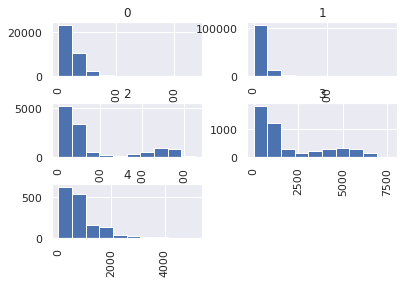

In [28]:
df.hist(column='q', by='etat_trafic')

In [29]:
df.loc['2019-10-01 00:00:00+00:00']

iu_ac  iu_nd_amont  iu_nd_aval       q  \
datetime                                                            
2019-10-01 00:00:00+00:00   5432         2796        2800  2994.0   
2019-10-01 00:00:00+00:00   7205         3734         674   185.0   
2019-10-01 00:00:00+00:00   6626         3433        3434   200.0   
2019-10-01 00:00:00+00:00    703          403         396   296.0   
2019-10-01 00:00:00+00:00   6018         3117        2271   692.0   
...                          ...          ...         ...     ...   
2019-10-01 00:00:00+00:00   4695         2502        2500   139.0   
2019-10-01 00:00:00+00:00   1430          759         760    23.0   
2019-10-01 00:00:00+00:00   5456         2863        2856  3255.0   
2019-10-01 00:00:00+00:00   5868          520        3046   325.0   
2019-10-01 00:00:00+00:00   4967         2629        2628     NaN   

                           etat_trafic        lat      long  Year  Month  \
datetime                                                                   
2019-10-01 00:00:00+00:00            1  48.871844  2.273661  2019     10   
2019-10-01 00:00:00+00:00            0  48.870523  2.398375  2019     10   
2019-10-01 00:00:00+00:00            1  48.876327  2.378870  2019     10   
2019-10-01 00:00:00+00:00            0  48.828528  2.324679  2019     10   
2019-10-01 00:00:00+00:00            1  48.875192  2.311696  2019     10   
...                                ...        ...       ...   ...    ...   
2019-10-01 00:00:00+00:00            1  48.849198  2.390751  2019     10   
2019-10-01 00:00:00+00:00            1  48.867534  2.409054  2019     10   
2019-10-01 00:00:00+00:00            1  48.855955  2.256930  2019     10   
2019-10-01 00:00:00+00:00            1  48.836202  2.404492  2019     10   
2019-10-01 00:00:00+00:00            0  48.825843  2.346234  2019     10   

                           Weekday  Hour  
datetime                                  
2019-10-01 00:00:00+00:00        1     0  
2019-10-01 00:00:00+00:00        1     0  
2019-10-01 00:00:00+00:00        1     0  
2019-10-01 00:00:00+00:00        1     0  
2019-10-01 00:00:00+00:00        1     0  
...                            ...   ...  
2019-10-01 00:00:00+00:00        1     0  
2019-10-01 00:00:00+00:00        1     0  
2019-10-01 00:00:00+00:00        1     0  
2019-10-01 00:00:00+00:00        1     0  
2019-10-01 00:00:00+00:00        1     0  

[3696 rows x 11 columns]

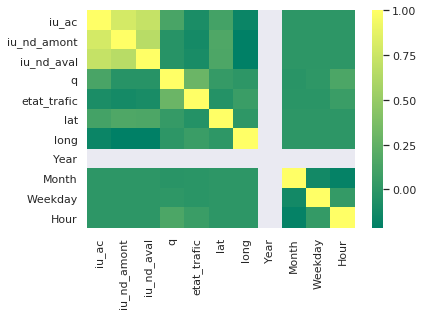

In [30]:
sns.heatmap(df.corr(), cmap='summer')

/home/ejoz/Bureau/traffic-jam-prediction/venv-jam/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


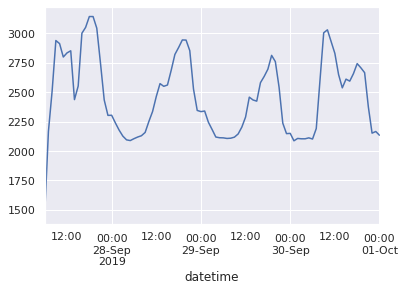

In [31]:
by_hour = df['etat_trafic'].resample('H').sum()
by_hour.plot()

# TO DO
- NaN
- Modelling (Classification, RNN)
- Predictions
- Graph optimization

## Classification

In [32]:
np.random.seed(42)

In [33]:
X = df[['Hour', 'Weekday', 'iu_ac', 'iu_nd_amont', 'iu_nd_aval', 'q']]
X

Hour  Weekday  iu_ac  iu_nd_amont  iu_nd_aval  \
datetime                                                                   
2019-10-01 00:00:00+00:00     0        1   5432         2796        2800   
2019-09-30 23:00:00+00:00    23        0   5432         2796        2800   
2019-09-30 22:00:00+00:00    22        0   5432         2796        2800   
2019-09-30 21:00:00+00:00    21        0   5432         2796        2800   
2019-09-30 20:00:00+00:00    20        0   5432         2796        2800   
...                         ...      ...    ...          ...         ...   
2019-09-27 10:00:00+00:00    10        4   4967         2629        2628   
2019-09-27 09:00:00+00:00     9        4   4967         2629        2628   
2019-09-27 08:00:00+00:00     8        4   4967         2629        2628   
2019-09-27 07:00:00+00:00     7        4   4967         2629        2628   
2019-09-27 06:00:00+00:00     6        4   4967         2629        2628   

                                q  
datetime                           
2019-10-01 00:00:00+00:00  2994.0  
2019-09-30 23:00:00+00:00  3309.0  
2019-09-30 22:00:00+00:00  3893.0  
2019-09-30 21:00:00+00:00  5312.0  
2019-09-30 20:00:00+00:00  5557.0  
...                           ...  
2019-09-27 10:00:00+00:00     NaN  
2019-09-27 09:00:00+00:00     NaN  
2019-09-27 08:00:00+00:00     NaN  
2019-09-27 07:00:00+00:00     NaN  
2019-09-27 06:00:00+00:00     NaN  

[335170 rows x 6 columns]

In [34]:
y = df[['etat_trafic']]
y

etat_trafic
datetime                              
2019-10-01 00:00:00+00:00            1
2019-09-30 23:00:00+00:00            1
2019-09-30 22:00:00+00:00            1
2019-09-30 21:00:00+00:00            1
2019-09-30 20:00:00+00:00            2
...                                ...
2019-09-27 10:00:00+00:00            0
2019-09-27 09:00:00+00:00            0
2019-09-27 08:00:00+00:00            0
2019-09-27 07:00:00+00:00            0
2019-09-27 06:00:00+00:00            0

[335170 rows x 1 columns]

### To complete

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').